# CIFAR-10 이미지 생성하기

<br>

## 데이터셋 구성하기

In [1]:
import tensorflow as tf

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [2]:
# 픽셀 확인
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


### 시각화

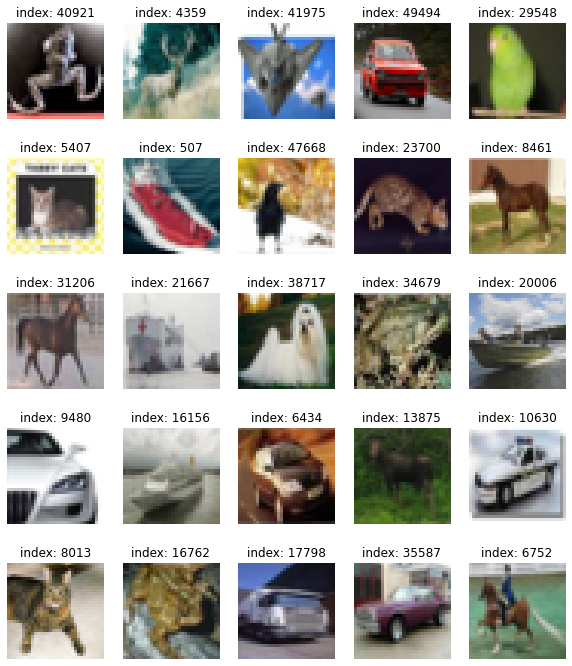

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(10,12))

for i in range(25):
    plt.subplot(5,5,i+1)
    random_index = np.random.randint(50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

### 정규화

In [4]:
# 각 픽셀 (-1,1)로 정규화
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


### Mini batch 데이터셋 구성

In [5]:
BUFFER_SIZE = 50000
BATCH_SIZE = 32

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator 구현하기
- Generator: random noise로부터 연산을 통해 이미지 형상의 vector 생성
- Discriminator: 진짜 이미지와 generator로부터 생성된 이미지를 input으로 각 이미지가 진짜인지 가짜인지 판단

<br>

### (32,32,3) image generating model
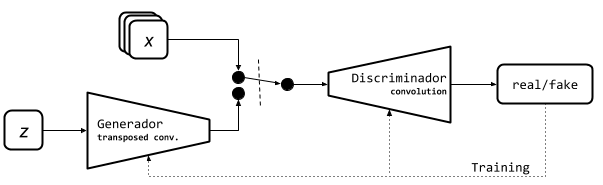

In [7]:
from tensorflow.keras import layers, initializers
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    init = initializers.RandomNormal(stddev=0.02)
    # First: Dense layer (FC) (2,2,512)
    model.add(layers.Dense(2*2*512, use_bias=False, input_shape=(100,), kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Second: Reshape layer 
    model.add(layers.Reshape((2, 2, 512)))

    # Third: Conv2DTranspose layer (4,4,256)
    model.add(layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Fourth: Conv2DTranspose layer (8,8,128)
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    # Fifth: Conv2DTranspose layer (16,16,64)
    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Sixth: Conv2DTranspose layer (32,32,3)
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [8]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              204800    
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 256)         0

In [9]:
#tf.keras.utils.plot_model(generator, show_shapes = True, show_layer_names = False)

### Random Image 생성하기

In [10]:
# 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 생성
noise = tf.random.normal([1, 100])
# 학습이 아니므로 False
generated_image = generator(noise, training=False)
### 출력 규격에 맞는지 확인
generated_image.shape

TensorShape([1, 32, 32, 3])

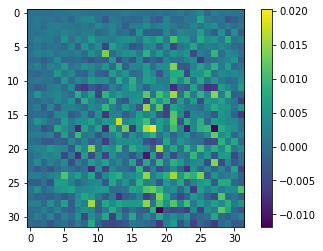

In [11]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## Discriminator 구현
 
<br>

### (32,32,3) image generating model

In [12]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    init = initializers.RandomNormal(stddev=0.02)
    # First: Conv2D Layer (16,16,64)
    model.add(layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[32,32,3],
                           kernel_initializer=init))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer (8,8,128)
    model.add(layers.Conv2D(128, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Conv2D Layer (4,4,256)
    model.add(layers.Conv2D(256, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth: Conv2D Layer (2,2,512)
    model.add(layers.Conv2D(512, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # FC
    model.add(layers.Flatten())

    # Output: Dense Layer
    model.add(layers.Dense(1))

    return model


In [13]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

In [14]:
# 1.2.2에서 생성한 랜덤 이미지를 해당 discriminator가 판별한 결과값을 확인해 봅시다.
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[9.108874e-05]], dtype=float32)>

## Loss Function과 Optimizer 구현하기
- loss function으로 Cross Entropy 사용

In [15]:
# 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Generator Loss, Discriminator Loss

In [16]:
# fake output 1에 가까워야 함 (real image가 1이라고 했을 때, 
# fake output이 1에 가까운 값을 가진다는 것은 real 값에 가깝다는 뜻)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
# discriminator에게 있어서는 가짜와 진짜를 판별하는 역할을 하므로
# real_output은 1에 가깝고, fake_output은 0에 가깝도록.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Discriminator Accuracy

In [18]:
# real output, fake output을 얼마나 정확하게 판별하는지 확인해야 함.
# real accuracy와 fake accuracy는 처음에 1.0에 가깝다가 0.5에 가까워지는 것이 이상적.
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### Optimizer

In [19]:
# 생성자와 판별자 각각 optimizer 따로 필요
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [20]:
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 상세 기능 구현하기

### 미니배치 훈련 과정 처리

In [21]:
@tf.function
def train_step(images):  #(1) 입력데이터
    # noise를 batch_size만큼 생성
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈
    # Gradient를 자동미분으로 계산
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        # noise 입력받은 후 Fake Image 생성
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        # real image인 images 받아 판별
        real_output = discriminator(images, training=True)
        # fake image인 generated_images 받아 판별
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


### 훈련 과정에서 생성한 이미지 시각화

In [22]:
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):

        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### Accuracy 시각화

In [23]:
# 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### Checkpoints 저장

In [24]:
import os
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

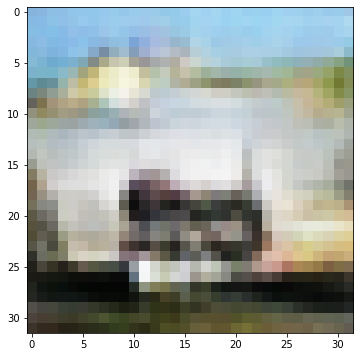

In [31]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show() 

## 학습 과정 진행하기

In [26]:
from IPython import display
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
import time
# 모델 학습
save_every = 5
EPOCHS = 70

16


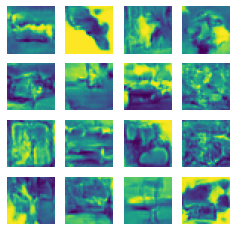

Time for training : 3725 sec


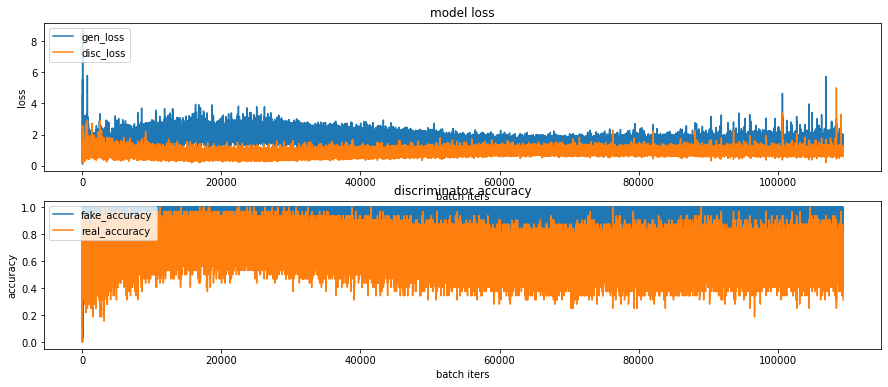

CPU times: user 23min 28s, sys: 53.8 s, total: 24min 22s
Wall time: 1h 2min 8s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

In [29]:
import imageio
import glob
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10.gif

ls: cannot access '/home/aiffel0036/aiffel/dcgan_newimage/cifar10/cifar10.gif': No such file or directory


[cifar10 학습과정 gif](https://github.com/yooonjiwon/Aiffel/blob/master/exploration/e16_cifar10_generator/cifar10_dcgan.gif)